In [2]:
import cv2
import mediapipe as mp
import os

C:\Users\elina\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
PHOTO_PATH = os.path.join('../photos')
CROPPED_PATH = os.path.join('cropped')
ASL_PATH = os.path.join('../ASL_digits')

In [4]:
numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [5]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [65]:
def make_dirs():
    if not os.path.exists(CROPPED_PATH):
        os.mkdir(CROPPED_PATH)

    for number in numbers:
        path = os.path.join(CROPPED_PATH, number)
        if not os.path.exists(path):
            os.mkdir(path)

In [76]:
make_dirs()

In [77]:
 for number in numbers:
        folder_path = os.path.join(PHOTO_PATH, number)
        photos_name = [f for f in os.listdir(folder_path)]
        
        for file_name in photos_name:
            file = os.path.join(PHOTO_PATH, number, file_name)
            img = cv2.imread(file)
            with mp_hands.Hands(static_image_mode=True) as hands:
                results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if results.multi_hand_landmarks:
                    if len(results.multi_hand_landmarks) == 1:
                        for hand_landmarks in results.multi_hand_landmarks:
                            x_min = min([landmark.x for landmark in hand_landmarks.landmark])
                            x_max = max([landmark.x for landmark in hand_landmarks.landmark])
                            y_min = min([landmark.y for landmark in hand_landmarks.landmark])
                            y_max = max([landmark.y for landmark in hand_landmarks.landmark])
                          
                            if x_max > 1:
                                x_max = 1
                            if y_max > 1:
                                y_max = 1
                            if x_min < 0:
                                x_min = 0
                            if y_min < 0:
                                y_min = 0
                            x_min, y_min = mp_drawing._normalized_to_pixel_coordinates(x_min, y_min, img.shape[1], img.shape[0])
                            x_max, y_max = mp_drawing._normalized_to_pixel_coordinates(x_max, y_max, img.shape[1], img.shape[0])
                            cropped_img = img[y_min:y_max, x_min:x_max]
                            cropped_img = cv2.resize(cropped_img, (64, 64), interpolation = cv2.INTER_AREA)
                            cv2.imwrite(os.path.join(CROPPED_PATH, number, file_name), cropped_img)
                    if len(results.multi_hand_landmarks) == 2:
                        lm = []
                        for hand_landmarks in results.multi_hand_landmarks:
                            x_min = min([landmark.x for landmark in hand_landmarks.landmark])
                            x_max = max([landmark.x for landmark in hand_landmarks.landmark])
                            y_min = min([landmark.y for landmark in hand_landmarks.landmark])
                            y_max = max([landmark.y for landmark in hand_landmarks.landmark])
                            lm.append([x_min, x_max, y_min, y_max])
                        x_min, y_min = min(lm[0][0], lm[1][0]), min(lm[0][2], lm[1][2])
                        x_max, y_max = max(lm[0][1], lm[1][1]), max(lm[0][3], lm[1][3])
                       
                        if x_max > 1:
                            x_max = 1
                        if y_max > 1:
                            y_max = 1
                        if x_min < 0:
                            x_min = 0
                        if y_min < 0:
                            y_min = 0
                        x_min, y_min = mp_drawing._normalized_to_pixel_coordinates(x_min, y_min, img.shape[1], img.shape[0])
                        x_max, y_max = mp_drawing._normalized_to_pixel_coordinates(x_max, y_max, img.shape[1], img.shape[0])
                        cropped_img = img[y_min:y_max, x_min:x_max]
                        cropped_img = cv2.resize(cropped_img, (64, 64), interpolation = cv2.INTER_AREA)
                        cv2.imwrite(os.path.join(CROPPED_PATH, number, file_name), cropped_img)

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
label_map = {label: num for num, label in enumerate(numbers)}

In [8]:
X, y = [], []
for number in numbers:
    data_path = os.path.join(CROPPED_PATH, number)
    imgs_name = [f for f in os.listdir(data_path)]
    for img_name in imgs_name:
        img = cv2.imread(os.path.join(CROPPED_PATH, number, img_name))
        X.append(img)
        y.append(label_map[number])

In [9]:
X = np.array(X)
y = to_categorical(y).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape)
print(y_train.shape)

<IPython.core.display.Javascript object>

(2534, 64, 64, 3)
(2534, 10)


In [14]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [15]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 256)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                15745088  
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 15,752,906
Trainable params: 15,752,906
Non-trainable params: 0
__________________________________________

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [13]:
history_fit = model.fit(X, y, epochs=5, batch_size=50, validation_split=0.2)

Epoch 1/5
51/51 [==============================] - 14s 246ms/step - loss: 258.3272 - accuracy: 0.1354 - val_loss: 2.3390 - val_accuracy: 0.0000e+00
Epoch 2/5
51/51 [==============================] - 12s 230ms/step - loss: 2.2862 - accuracy: 0.1413 - val_loss: 2.3910 - val_accuracy: 0.0000e+00
Epoch 3/5
51/51 [==============================] - 12s 227ms/step - loss: 2.2732 - accuracy: 0.1413 - val_loss: 2.4401 - val_accuracy: 0.0000e+00
Epoch 4/5
51/51 [==============================] - 11s 225ms/step - loss: 2.2611 - accuracy: 0.1413 - val_loss: 2.4882 - val_accuracy: 0.0000e+00
Epoch 5/5
51/51 [==============================] - 11s 224ms/step - loss: 2.2499 - accuracy: 0.1413 - val_loss: 2.5355 - val_accuracy: 0.0000e+00


In [15]:
if not os.path.exists("model"):
    os.mkdir("model")
model.save(os.path.join("model", 'CNN'))

INFO:tensorflow:Assets written to: model\CNN\assets


INFO:tensorflow:Assets written to: model\CNN\assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

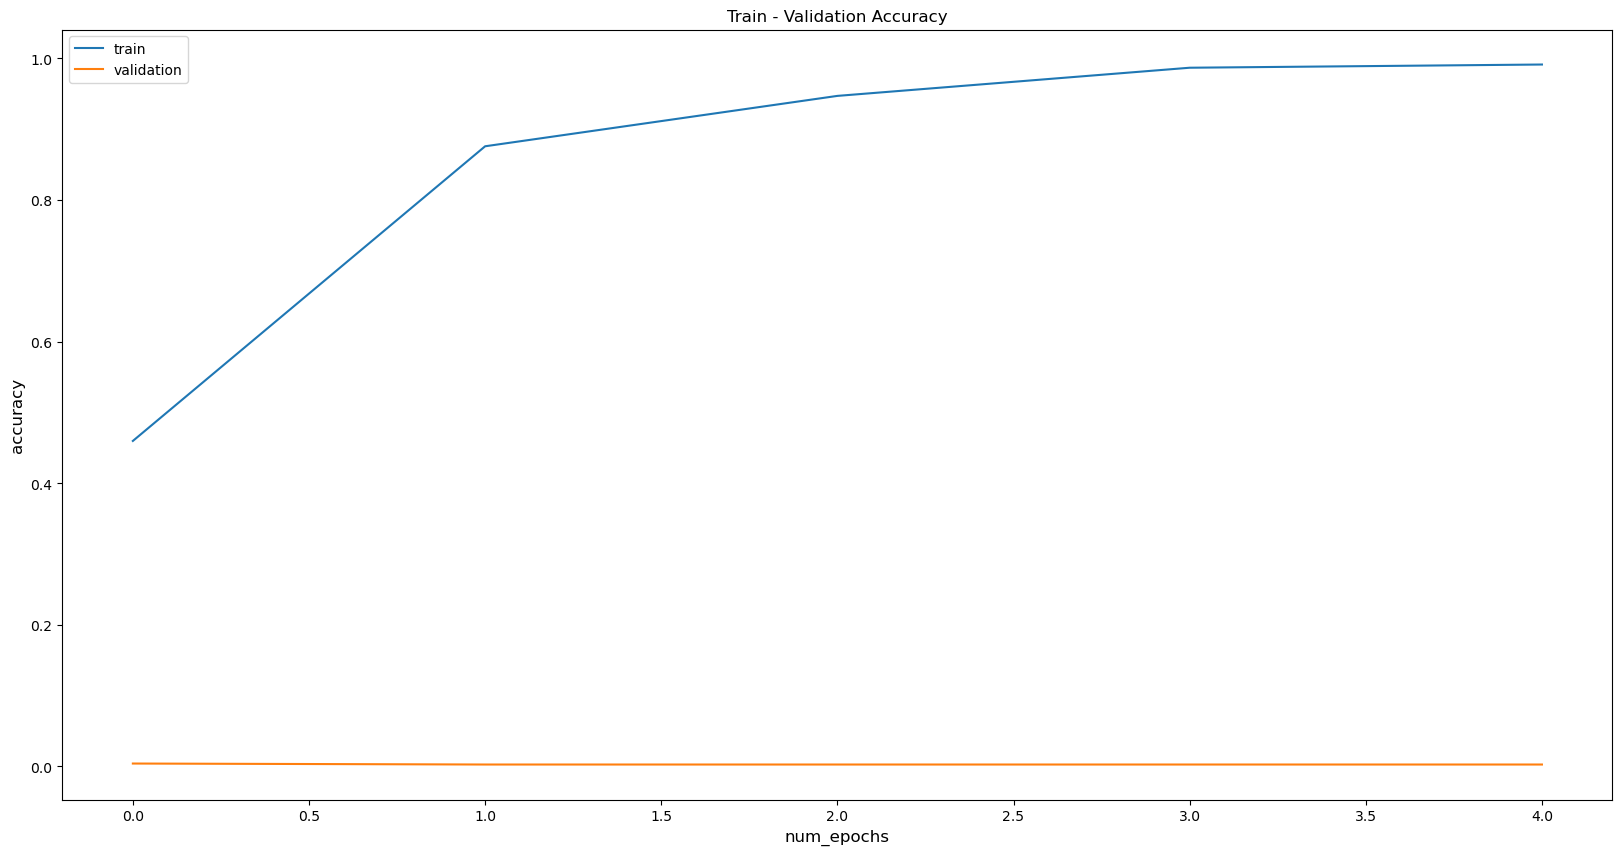

In [131]:
fig1 = plt.figure(figsize=(20, 10))
plt.title("Train - Validation Accuracy")
plt.plot(history_fit.history['accuracy'], label='train')
plt.plot(history_fit.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

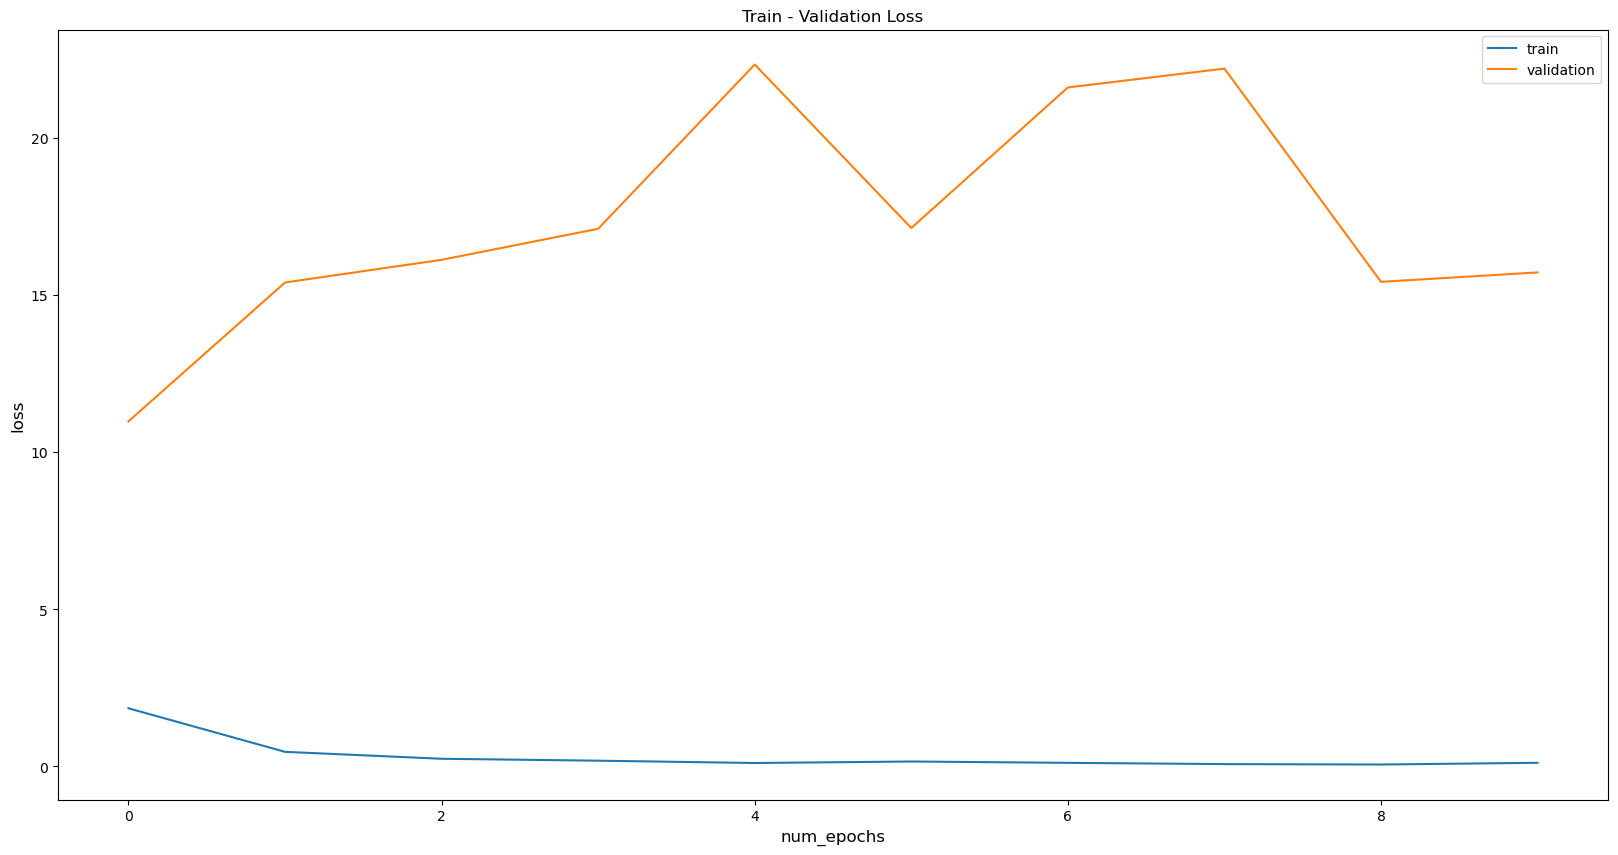

In [88]:
fig2 = plt.figure(figsize=(20, 10))
plt.title("Train - Validation Loss")
plt.plot(history_fit.history['loss'], label='train')
plt.plot(history_fit.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [92]:
scores = model.evaluate(X_train, y_train)
print("Доля верных ответов на тестовых данных в процентах:", round(scores[1] * 100, 4))

90/90 [==============================] - 5s 52ms/step - loss: 5.0848 - accuracy: 0.8022
Доля верных ответов на тестовых данных в процентах: 80.2232


In [90]:
predictions = model.predict(X_test)
print(np.argmax(predictions[123]), np.argmax(y_test[123]))

23/23 [==============================] - 2s 59ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1 1


In [21]:
img = cv2.imread(os.path.join('cropped', '1', 'WOMAN_0_22.png'))
print(np.array(img).shape)
prediction = model.predict([img])
print(np.argmax(prediction))

<IPython.core.display.Javascript object>

(64, 64, 3)


ValueError: in user code:

    File "C:\Users\elina\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\elina\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\elina\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\elina\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "C:\Users\elina\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\elina\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(32, 64, 3)


In [7]:
X, y = [], []
for number in numbers:
    data_path = os.path.join(ASL_PATH, number)
    imgs_name = [f for f in os.listdir(data_path)]
    for img_name in imgs_name:
        img = cv2.imread(os.path.join(ASL_PATH, number, img_name))
        X.append(img)
        y.append(label_map[number])

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '../ASL_digits\\10'

In [ ]:
X = np.array(X)
y = to_categorical(y).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape)
print(y_train.shape)

In [ ]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))